In [8]:
# TO DO
# - plot % citizenship against language spoken at home: temporal aspect?
# - plot median household income against language spoken at home
# - make 'fastest growing language' graph interactive with tooltip
# - write up analysis
# - figure out how to configure notebook cells to display or not

# Setup

In [304]:
# setup
# import libraries
import os
import glob
import hashlib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

# show all outputs from each cell, not just the last
InteractiveShell.ast_node_interactivity = 'all'

# configure directories
wd = os.getcwd()
if not os.path.isdir('data'):
    os.mkdir('data')
dd = os.path.join(wd, 'data')
if not os.path.isdir('output'):
    os.mkdir('output')
od = os.path.join(wd, 'output')

# define custom functions
def glimpse(df):
    print(f'Rows: {df.shape[0]}')
    print(f'Columns: {df.shape[1]}')
    for col in df.columns:
        print(f'$ {col} <{df[col].dtype}> {df[col].head().values}')

In [288]:
# load data
files = glob.glob(dd + '/*.csv')
files = [os.path.basename(x) for x in files]
files.remove('asc_2000-2021_languages_spoken.csv')

dfs = {}
for name in files:
    basename = 'd_' + name.replace('ipums_', '').replace('.csv', '')
    dfs[basename] = pd.read_csv(os.path.join(dd, name))

d_raw = pd.read_csv(os.path.join(dd, 'asc_2000-2021_languages_spoken.csv'))
dfs['d_raw'] = d_raw

dfs.keys()

dict_keys(['d_language', 'd_statefip', 'd_bpld', 'd_bpl', 'd_citizenship', 'd_gq', 'd_sample', 'd_languaged', 'd_raw'])

In [11]:
# initial exploration of data
for name, df in dfs.items():
    print(name)
    glimpse(df)

d_language
Rows: 93
Columns: 3
$ language_id <int64> [0 1 2 3 4]
$ language <object> ['N/A or blank' 'English' 'German' 'Yiddish, Jewish' 'Dutch']
$ language_group <object> ['Unknown' 'English' 'European' 'European' 'European']
d_statefip
Rows: 62
Columns: 3
$ statefip_id <int64> [1 2 4 5 6]
$ statefip <object> ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California']
$ statefip_geo_type <object> ['state' 'state' 'state' 'state' 'state']
d_bpld
Rows: 572
Columns: 2
$ bpld_id <float64> [ nan 100. 200. 400. 500.]
$ birthplace_detailed <object> ['UNITED STATES' 'Alabama' 'Alaska' 'Arizona' 'Arkansas']
d_bpl
Rows: 188
Columns: 2
$ bpl_id <float64> [nan  1.  2.  4.  5.]
$ birthplace <object> ['UNITED STATES' 'Alabama' 'Alaska' 'Arizona' 'Arkansas']
d_citizenship
Rows: 8
Columns: 2
$ citizenship_id <int64> [0 1 2 3 4]
$ citizenship_status <object> [nan 'Born abroad of American parents' 'Naturalized citizen'
 'Not a citizen' 'Not a citizen, but has received first papers']
d_gq
Rows: 7
Columns: 2

In [12]:
# clean up primary dataset

# IPUMS metadata reference: 
# https://live.usa.datadownload.ipums.org/web/extracts/usa/1931448/usa_00002.cbk
# https://usa.ipums.org/usa-action/extract_requests/summary
d_cleaned = (d_raw
    # clarify variable names
    .rename(
        str.lower,
        axis = 'columns'
    )
    .rename(
        columns = {
            'sample': 'sample_id',
            'statefip': 'statefip_id',
            'serial': 'hh_id', 
            'cbserial': 'hh_id_cb',
            'gq': 'gq_id',
            'bpl': 'bpl_id',
            'bpld': 'bpld_id',
            'citizen': 'citizenship_id',
            'language': 'language_id',
            'languaged': 'languaged_id',
            'ftotinc': 'family_gross_income_total',
            'incwelfr': 'person_gross_income_welfare',
            'poverty': 'family_gross_income_pct_of_poverty_line'
        }
    )
    # drop unneeded variables
    .drop(
        ['qcitizen', 'qlanguag', 'qftotinc', 'qincwelf'],
        axis = 'columns'
    )
    # transform income_pct_of_poverty_line into decimal, e.g. 1 = 100%
    .assign(family_gross_income_pct_of_poverty_line = 
        lambda x: x.family_gross_income_pct_of_poverty_line/100)
)

# create unique person id combining sample, hh_id, and pernum
d_cleaned['person_id'] = (
    d_cleaned['sample_id']
    + d_cleaned['hh_id']
    + d_cleaned['pernum']
)

d_cleaned['person_id'] = d_cleaned['person_id'].astype(str).apply(
    lambda x: hashlib.sha256(x.encode()).hexdigest()
)

# N.B.: income data is not adjusted for inflation
# https://usa.ipums.org/usa-action/variables/FTOTINC#description_section

glimpse(d_cleaned)


Rows: 2208258
Columns: 21
$ year <int64> [2000 2000 2000 2000 2000]
$ sample_id <int64> [200004 200004 200004 200004 200004]
$ hh_id <int64> [ 1  1 11 11 30]
$ hh_id_cb <float64> [nan nan nan nan nan]
$ hhwt <float64> [600. 600. 600. 600. 600.]
$ cluster <int64> [2000000000014 2000000000014 2000000000114 2000000000114 2000000000304]
$ statefip_id <int64> [17 17 17 17 17]
$ strata <int64> [17 17 17 17 17]
$ cpuma0010 <float64> [nan nan nan nan nan]
$ gq_id <int64> [1 1 1 1 1]
$ pernum <int64> [1 2 1 2 1]
$ perwt <float64> [618. 684. 611. 518. 704.]
$ bpl_id <int64> [ 17  17 414  40  17]
$ bpld_id <int64> [ 1700  1700 41400  4000  1700]
$ citizenship_id <int64> [0 0 3 0 0]
$ language_id <int64> [1 1 1 1 1]
$ languaged_id <int64> [100 100 100 100 100]
$ family_gross_income_total <int64> [54700 54700 41100 41100 48500]
$ person_gross_income_welfare <int64> [0 0 0 0 0]
$ family_gross_income_pct_of_poverty_line <float64> [5.01 5.01 4.03 4.03 2.75]
$ person_id <object> ['bc36cf3d4feac69d771a5

In [13]:
# create custom function to review dataframes for common issues
def df_review(d: pd.DataFrame, id_col: str, str_col: str):
    """ Check dataframe for common issues

    Since we know the general structure of the dataframes we'll be examining
    have an id column and typically one string column, this function takes 
    three arguments:

    1. the dataframe to be examined
    2. the name, as a string, of the id column
    3. the name, as a string, of the string column

    Both the id and string columns will be searched for nulls and uniqueness.
    If there are any values with multiple counts, they will be listed out.

    """

    # examine range of numeric values
    print(d.describe())
    print()
    # check for NAs
    print(
        'N/A tally: ' 
        + str(d[id_col].isna().value_counts()) 
        + '\n'
    )
    print(
        'IDs all unique: ' 
        + str(d[id_col].dropna().is_unique) 
        + '\n'
    )
    print('IDs with multiples:')
    print(str(d[id_col].value_counts().loc[lambda x : x > 1]))
    print()
    print(
        'String values all unique: ' 
        + str(d[str_col].dropna().is_unique) 
        + '\n'
    )
    print('Values with multiples:')
    print(str(d[str_col].value_counts().loc[lambda x : x > 1]))

In [14]:
# clean: d_language
d_language = dfs['d_language']
df_review(d_language, 'language_id', 'language')

# >>> no issues

       language_id
count    93.000000
mean     47.526882
std      28.895084
min       0.000000
25%      23.000000
50%      46.000000
75%      74.000000
max      99.000000

N/A tally: False    93
Name: language_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: language_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: language, dtype: int64)


In [15]:
# clean: d_languaged
d_languaged = dfs['d_languaged']
df_review(d_languaged, 'languaged_id', 'language_detailed')

# >>> 8 values non-unique; not sure why...
# >>> 25 nulls --> get rid of them
d_languaged[d_languaged['languaged_id'].isna()]
d_languaged = d_languaged[d_languaged.languaged_id.notna()]

# re-check cleaned dataframe
df_review(d_languaged, 'languaged_id', 'language_detailed')
# >>> all good; the 8 values originally with two different ids were labels

       languaged_id
count    497.000000
mean    5562.074447
std     2738.443717
min        0.000000
25%     3190.000000
50%     5720.000000
75%     7920.000000
max     9900.000000

N/A tally: False    497
True      25
Name: languaged_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: languaged_id, dtype: int64)

String values all unique: False

Values with multiples:
Arawakian            2
Mapuche              2
Chibchan             2
Hamitic              2
Penutian-Sahaptin    2
Oto-Manguen          2
Tupi-Guarani         2
Other Chinese        2
Name: language_detailed, dtype: int64


,languaged_id,language_detailed
96,NaN,Other Persian dialects:
108,NaN,Other Indo-Aryan:
170,NaN,Other Chinese
191,NaN,Other East/Southeast Asian:
208,NaN,Other Malayan:
223,NaN,"Miconesian, Polynesian"
263,NaN,Hamitic
269,NaN,Sub-Saharan Africa:
285,NaN,"Sub-Saharan Africa (1960, 1970 only):"
358,NaN,Penutian-Sahaptin


       languaged_id
count    497.000000
mean    5562.074447
std     2738.443717
min        0.000000
25%     3190.000000
50%     5720.000000
75%     7920.000000
max     9900.000000

N/A tally: False    497
Name: languaged_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: languaged_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: language_detailed, dtype: int64)


In [16]:
# clean: d_statefip
d_statefip = dfs['d_statefip']
df_review(d_statefip, 'statefip_id', 'statefip')

# >>> no issues

       statefip_id
count    62.000000
mean     36.467742
std      22.387583
min       1.000000
25%      19.250000
50%      34.500000
75%      50.750000
max      99.000000

N/A tally: False    62
Name: statefip_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: statefip_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: statefip, dtype: int64)


In [17]:
# clean: d_bpl
d_bpl = dfs['d_bpl']
df_review(d_bpl, 'bpl_id', 'birthplace')

# >>> 25 NAs and one multiple, probably headers that need to be dropped
d_bpl = d_bpl[d_bpl.bpl_id.notna()]

# re-check cleaned dataframe
df_review(d_bpl, 'bpl_id', 'birthplace')
# >>> all good

           bpl_id
count  163.000000
mean   320.171779
std    236.187350
min      1.000000
25%     45.500000
50%    421.000000
75%    512.500000
max    999.000000

N/A tally: False    163
True      25
Name: bpl_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: bpl_id, dtype: int64)

String values all unique: False

Values with multiples:
AFRICA    2
Name: birthplace, dtype: int64
           bpl_id
count  163.000000
mean   320.171779
std    236.187350
min      1.000000
25%     45.500000
50%    421.000000
75%    512.500000
max    999.000000

N/A tally: False    163
Name: bpl_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: bpl_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: birthplace, dtype: int64)


In [18]:
# clean: d_bpld
d_bpld = dfs['d_bpld']
df_review(d_bpld, 'bpld_id', 'birthplace_detailed')

# >>> 35 NAs and a few multiples, probably headers that need to be dropped
d_bpld = d_bpld[d_bpld.bpld_id.notna()]

# re-check cleaned dataframe
df_review(d_bpld, 'bpld_id', 'birthplace_detailed')
# >>> still a duplicate in birthplace_detailed but with different ids

d_bpld[d_bpld.birthplace_detailed == 'Br. Virgin Islands, ns']
# >>> unclear why, but we'll keep it for now

            bpld_id
count    537.000000
mean   40447.891993
std    21467.446617
min      100.000000
25%    26044.000000
50%    45319.000000
75%    54700.000000
max    99900.000000

N/A tally: False    537
True      35
Name: bpld_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: bpld_id, dtype: int64)

String values all unique: False

Values with multiples:
Br. Virgin Islands, ns    2
West Germany              2
East Germany              2
Name: birthplace_detailed, dtype: int64
            bpld_id
count    537.000000
mean   40447.891993
std    21467.446617
min      100.000000
25%    26044.000000
50%    45319.000000
75%    54700.000000
max    99900.000000

N/A tally: False    537
Name: bpld_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: bpld_id, dtype: int64)

String values all unique: False

Values with multiples:
Br. Virgin Islands, ns    2
Name: birthplace_detailed, dtype: int64


,bpld_id,birthplace_detailed
147,26052.0,"Br. Virgin Islands, ns"
157,26069.0,"Br. Virgin Islands, ns"


In [289]:
# clean: d_citizenship
d_citizenship = dfs['d_citizenship']
df_review(d_citizenship, 'citizenship_id', 'citizenship_status')
# >>> all good

       citizenship_id
count        8.000000
mean         4.000000
std          3.207135
min          0.000000
25%          1.750000
50%          3.500000
75%          5.750000
max          9.000000

N/A tally: False    8
Name: citizenship_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: citizenship_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: citizenship_status, dtype: int64)


In [20]:
# clean: d_gq
d_gq = dfs['d_gq']
df_review(d_gq, 'gq_id', 'group_quarters_status')
# >>> all good

          gq_id
count  7.000000
mean   3.000000
std    2.160247
min    0.000000
25%    1.500000
50%    3.000000
75%    4.500000
max    6.000000

N/A tally: False    7
Name: gq_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: gq_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: group_quarters_status, dtype: int64)


In [21]:
# clean: d_sample
d_sample = dfs['d_sample']
df_review(d_sample, 'sample_id', 'source')
# >>> all good

           sample_id
count     139.000000
mean   198175.697842
std      4664.123861
min    185001.000000
25%    197004.500000
50%    200602.000000
75%    201253.500000
max    202102.000000

N/A tally: False    139
Name: sample_id, dtype: int64

IDs all unique: True

IDs with multiples:
Series([], Name: sample_id, dtype: int64)

String values all unique: True

Values with multiples:
Series([], Name: source, dtype: int64)


In [290]:
# join dimensional data
d = (d_cleaned
    .merge(d_bpl, how = 'left', on = 'bpl_id')
    .merge(d_bpld, how = 'left', on = 'bpld_id')
    .merge(d_citizenship, how = 'left', on = 'citizenship_id')
    .merge(d_gq, how = 'left', on = 'gq_id')
    .merge(d_language, how = 'left', on = 'language_id')
    .merge(d_languaged, how = 'left', on = 'languaged_id')
    .merge(d_sample, how = 'left', on = 'sample_id')
    .merge(d_statefip, how = 'left', on = 'statefip_id')
)
glimpse(d)

Rows: 2208258
Columns: 31
$ year <int64> [2000 2000 2000 2000 2000]
$ sample_id <int64> [200004 200004 200004 200004 200004]
$ hh_id <int64> [ 1  1 11 11 30]
$ hh_id_cb <float64> [nan nan nan nan nan]
$ hhwt <float64> [600. 600. 600. 600. 600.]
$ cluster <int64> [2000000000014 2000000000014 2000000000114 2000000000114 2000000000304]
$ statefip_id <int64> [17 17 17 17 17]
$ strata <int64> [17 17 17 17 17]
$ cpuma0010 <float64> [nan nan nan nan nan]
$ gq_id <int64> [1 1 1 1 1]
$ pernum <int64> [1 2 1 2 1]
$ perwt <float64> [618. 684. 611. 518. 704.]
$ bpl_id <int64> [ 17  17 414  40  17]
$ bpld_id <int64> [ 1700  1700 41400  4000  1700]
$ citizenship_id <int64> [0 0 3 0 0]
$ language_id <int64> [1 1 1 1 1]
$ languaged_id <int64> [100 100 100 100 100]
$ family_gross_income_total <int64> [54700 54700 41100 41100 48500]
$ person_gross_income_welfare <int64> [0 0 0 0 0]
$ family_gross_income_pct_of_poverty_line <float64> [5.01 5.01 4.03 4.03 2.75]
$ person_id <object> ['bc36cf3d4feac69d771a5

In [291]:
# account for sample weighting

# check: what are the sources for these data?
d.source.value_counts(sort = False)
# >>> all ACS, which means they are weighted samples
#     https://usa.ipums.org/usa-action/faq#ques8

# create a dataset for person-level analysis
var_p = (['year', 'person_id', 'perwt', 'person_gross_income_welfare'] + 
    list(d.loc[:, 'birthplace_detailed':].columns))

d_wp = d.loc[:, var_p]
print("d_wp:")
glimpse(d_wp)
print()

# create a dataset for household-level analysis
var_h = (['year', 'hh_id', 'hhwt', 'cluster', 'strata', 
    'family_gross_income_total', 'family_gross_income_pct_of_poverty_line'] + 
    list(d.loc[:, 'citizenship_status':].columns))
d_wh = d.loc[d.pernum == 1, var_h]
print("d_wh:")
glimpse(d_wh)


2000 ACS     15371
2001 ACS     45647
2002 ACS     41942
2003 ACS     46116
2004 ACS     45612
2005 ACS    123074
2006 ACS    126613
2007 ACS    127458
2008 ACS    126618
2009 ACS    126758
2010 ACS    126570
2011 ACS    127034
2012 ACS    127208
2013 ACS    128070
2014 ACS    126650
2015 ACS    126642
2016 ACS    126334
2017 ACS    126482
2018 ACS    126456
2019 ACS    125007
2020 ACS    116596
Name: source, dtype: int64

d_wp:
Rows: 2208258
Columns: 13
$ year <int64> [2000 2000 2000 2000 2000]
$ person_id <object> ['bc36cf3d4feac69d771a5e7126e23732f433404fe0836cc1c47c65ee9b22d828'
 '65df969fbb15f1af68ec31054e465d8341739e7161f5774dc9e301560ba9450f'
 'de58f5f7ea8bc1be25382480c71c9d3a39d1957e804de484d5b5a495b7e66e0a'
 '2da71431d03a040149edcf688374925bd0183c867344334c14eabd101206d9f6'
 'd4b60d3a20560ec4a31153014c823b72ed873adbc0ad889654ee556756a39529']
$ perwt <float64> [618. 684. 611. 518. 704.]
$ person_gross_income_welfare <int64> [0 0 0 0 0]
$ birthplace_detailed <object> ['Illinois' 'Illinois' 'Ireland' 'Oklahoma' 'Illinois']
$ citizenship_status <object> ['Citizen' 'Citizen' 'Not a citizen' 'Citizen' 'Citizen']
$ group_quarters_status <object> ['Households under 1970 definition' 'Households under 1970 definition'
 'Households under 1970 definition' 'Households under 1970 definition'
 'Households under 1970 definition']
$ language <object> ['English' 'English' 'English' 'English' 'English']
$ language

In [292]:
# sum weights by year for person-level and household-level datasets
s_year_p = (d_wp
    .groupby('year')
    .agg(person_sum_weight = ('perwt', 'sum'))
)

s_year_h = (d_wh
    .groupby('year')
    .agg(household_sum_weight = ('hhwt', 'sum'))
)


s_year = s_year_p.merge(s_year_h, how = "left", on = "year")
s_year

,person_sum_weight,household_sum_weight
year,,
2000,12123016.0,4537800.0
2001,12174337.0,4600280.0
2002,12307000.0,4629012.0
2003,12338235.0,4625603.0
2004,12368348.0,4660053.0
2005,12441864.0,4682861.0
2006,12831970.0,5047897.0
2007,12852548.0,5082253.0
2008,12901564.0,5111591.0


# How has % of languages spoken at home changed over time in Illinois?

In [25]:
# create summary by year and language group
s_language_groups_over_time = (d_wp
    .groupby(['year', 'language_group'])
    .agg(n_sample = ('person_id', 'count'), sum_weight = ('perwt', 'sum'))
    .reset_index()
    .merge(s_year, how = "left", on = "year")
    .drop('household_sum_weight', axis = 'columns')
    .assign(pct_weight = lambda x: x.sum_weight/x.person_sum_weight)
)
s_language_groups_over_time

# double-check percents all add up to 100% by year
s_language_groups_over_time.groupby('year').agg(sum)

# drop English group
s_language_groups_plotme = s_language_groups_over_time[
    s_language_groups_over_time.language_group != 'English']

,year,language_group,n_sample,sum_weight,person_sum_weight,pct_weight
0,2000,African,17,17078.0,12123016.0,0.001409
1,2000,Asian,457,353313.0,12123016.0,0.029144
2,2000,English,11976,9072529.0,12123016.0,0.748372
3,2000,European,655,531475.0,12123016.0,0.043840
4,2000,Indigenous,1,605.0,12123016.0,0.000050
...,...,...,...,...,...,...
184,2020,Indigenous,14,1576.0,12559183.0,0.000125
185,2020,Middle Eastern,599,76185.0,12559183.0,0.006066
186,2020,Pacific Islander,1,183.0,12559183.0,0.000015
187,2020,Spanish,10459,1540916.0,12559183.0,0.122692


,n_sample,sum_weight,person_sum_weight,pct_weight
year,,,,
2000,15371,12123016.0,109107144.0,1.0
2001,45647,12174337.0,109569033.0,1.0
2002,41942,12307000.0,110763000.0,1.0
2003,46116,12338235.0,111044115.0,1.0
2004,45612,12368348.0,111315132.0,1.0
2005,123074,12441864.0,111976776.0,1.0
2006,126613,12831970.0,115487730.0,1.0
2007,127458,12852548.0,115672932.0,1.0
2008,126618,12901564.0,116114076.0,1.0


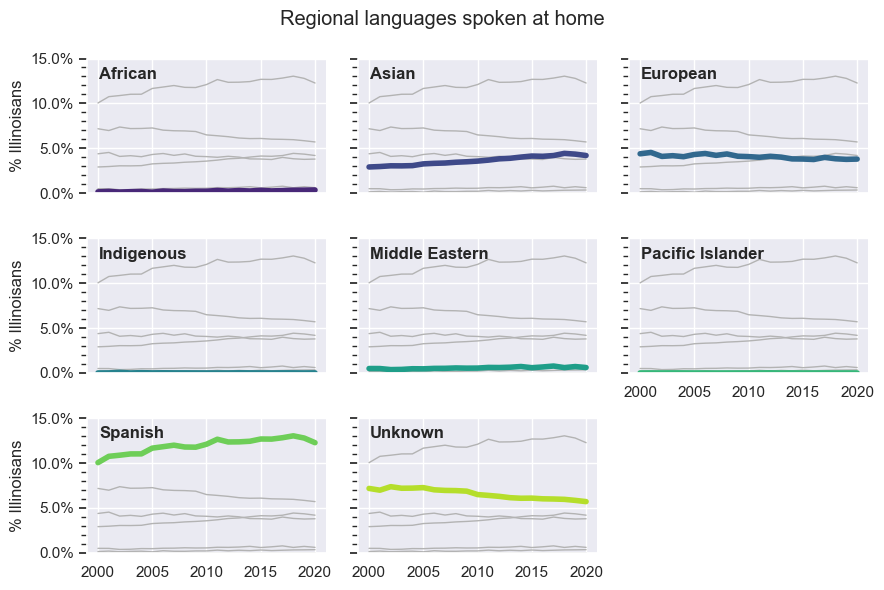

In [274]:
# plot

# temporarily only show final output
InteractiveShell.ast_node_interactivity = 'last_expr'

# set theme
sns.set_theme(
    style = 'darkgrid',
    rc = {
        'ytick.left' : True
    }
)

# create base figure
g_language_over_time = sns.relplot(
    data = s_language_groups_plotme,
    x = 'year', 
    y = 'pct_weight', 
    kind = 'line',
    col = 'language_group',
    col_wrap = 3,
    hue = 'language_group',
    palette = 'viridis',
    linewidth = 4,
    height = 2,
    aspect = 1.5,
    legend = False,
)

# format each subplot
for group, ax in g_language_over_time.axes_dict.items():

    # add the title as an annotation within the plot
    ax.text(
        x = 0.05, 
        y = 0.85,
        s = group,
        transform = ax.transAxes, 
        fontweight = 'bold'
    )

    # plot every language group's time series in the background
    sns.lineplot(
        data = s_language_groups_plotme, 
        x = 'year', 
        y = 'pct_weight', 
        units = 'language_group',
        estimator = None, 
        color = '0.7', 
        linewidth = 1, 
        ax = ax,
        zorder = 1
    )

    # format y-axis: ticks and as-percents
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    ax.set_ylim(0, 0.15)
    ax.minorticks_on()
    ax.set_yticks(np.arange(0, 0.16, 0.05))
    ax.set_yticks(np.arange(0, 0.16, 0.01), minor = True)

# add labels and title
g_language_over_time.set(
    title = '',
    xlabel = '',
    ylabel = '% Illinoisans'
)
g_language_over_time.fig.suptitle('Regional languages spoken at home')
g_language_over_time.tight_layout()

# save plot
g_language_over_time.savefig(os.path.join(od, 'regional_time_series.jpg'))

In [148]:
# which languages experienced most growth over 20 year period?

# go back to showing all outputs
InteractiveShell.ast_node_interactivity = 'all'

# store min and max years in dataset
start_year = min(d_wp.year)
end_year = max(d_wp.year)

# create summary by year and language
s_languages_over_time = (d_wp
    .groupby(['year', 'language_group', 'language'])
    .agg(n_sample = ('person_id', 'count'), sum_weight = ('perwt', 'sum'))
    .reset_index()
    .merge(s_year, how = "left", on = "year")
    .drop('household_sum_weight', axis = 1)
    .assign(pct_weight = lambda x: x.sum_weight/x.person_sum_weight)
)

# drop English
s_languages_over_time = s_languages_over_time[
    s_languages_over_time['language'] != 'English'
]
s_languages_over_time

# check if any languages have fewer than 21 years worth of data >>> yuuuuppp
s_languages_over_time.language.value_counts().loc[lambda x : x < 21]

# transform to wide data
s_language_growth_over_time = (pd.pivot(
    data = s_languages_over_time[
        s_languages_over_time['year'].isin(np.arange(start_year, end_year +1, 1))
    ],
    index = ['language', 'language_group'],
    columns = 'year',
    values = 'pct_weight'
    )
    .add_prefix('yr')
    .rename(columns = {'yr_language': 'language'})
    .reset_index()
    .fillna(0)
)
s_language_growth_over_time

# calculate n-year growth rates by language
s_language_growth_over_time = (s_language_growth_over_time
    .assign(
        growth_2015_2020 = lambda x: (x.yr2020-x.yr2015)/x.yr2015,
        growth_2010_2020 = lambda x: (x.yr2020-x.yr2010)/x.yr2010,
        growth_2000_2020 = lambda x: (x.yr2020-x.yr2010)/x.yr2010,
    )
    .replace([np.inf, -np.inf], np.nan)
)
(s_language_growth_over_time
    .sort_values(
        by = 'growth_2000_2020', 
        ascending = False,
        na_position = 'last'
    )
)

,year,language_group,language,n_sample,sum_weight,person_sum_weight,pct_weight
0,2000,African,"Amharic, Ethiopian, etc.",1,614.0,12123016.0,0.000051
1,2000,African,Sub-Saharan Africa,16,16464.0,12123016.0,0.001358
2,2000,Asian,Chinese,72,63785.0,12123016.0,0.005261
3,2000,Asian,Dravidian,33,22935.0,12123016.0,0.001892
4,2000,Asian,"Filipino, Tagalog",109,88445.0,12123016.0,0.007296
...,...,...,...,...,...,...,...
1162,2020,Middle Eastern,Near East Arabic dialect,81,9698.0,12559183.0,0.000772
1163,2020,Pacific Islander,"Micronesian, Polynesian",1,183.0,12559183.0,0.000015
1164,2020,Spanish,Spanish,10459,1540916.0,12559183.0,0.122692
1165,2020,Unknown,N/A or blank,5580,715203.0,12559183.0,0.056947


Finnish                         20
Yiddish, Jewish                 20
Native                          20
Other or not reported           19
Hamitic                         19
Other Malayan                   19
Micronesian, Polynesian         19
Burmese, Lisu, Lolo             18
Tibetan                         17
Other Persian dialects          16
Iroquoian                       13
African, n.s.                   13
Siouan languages                10
Navajo                           9
Other Altaic                     9
American Indian, n.s.            8
Athapascan                       8
Hawaiian                         8
Algonquian                       8
Aleut, Eskimo                    5
Other Afro-Asiatic languages     5
Keres                            2
Name: language, dtype: int64

year,language,language_group,yr2000,yr2001,yr2002,yr2003,yr2004,yr2005,yr2006,yr2007,...,yr2011,yr2012,yr2013,yr2014,yr2015,yr2016,yr2017,yr2018,yr2019,yr2020
0,"African, n.s.",African,0.000000,0.000063,0.000047,0.000019,0.000098,0.000089,0.000008,0.000026,...,0.000050,0.000012,0.000000,0.000044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Albanian,European,0.001358,0.001005,0.000428,0.000192,0.000628,0.000652,0.000308,0.000366,...,0.000686,0.001101,0.000983,0.001165,0.000950,0.000544,0.000780,0.001016,0.000652,0.000929
2,"Aleut, Eskimo",Indigenous,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000009,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002
3,Algonquian,Indigenous,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000020,0.000010,0.000014,0.000011,0.000051,0.000034,0.000020,0.000028
4,"American Indian, n.s.",Indigenous,0.000000,0.000040,0.000119,0.000000,0.000018,0.000000,0.000006,0.000012,...,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Tibetan,Asian,0.000000,0.000000,0.000020,0.000000,0.000085,0.000023,0.000023,0.000031,...,0.000116,0.000000,0.000066,0.000015,0.000025,0.000044,0.000076,0.000079,0.000031,0.000022
59,Turkish,Asian,0.000049,0.000239,0.000189,0.000248,0.000387,0.000389,0.000338,0.000152,...,0.000277,0.000291,0.000278,0.000443,0.000476,0.000427,0.000476,0.000494,0.000386,0.000314
60,"Ukrainian, Ruthenian, Little Russian",European,0.000815,0.000941,0.000933,0.000861,0.000738,0.000818,0.000830,0.000712,...,0.000896,0.001282,0.001378,0.001244,0.001332,0.001180,0.001582,0.001328,0.001420,0.001781
61,Vietnamese,Asian,0.001763,0.001825,0.001270,0.002233,0.001008,0.000943,0.001561,0.001715,...,0.001528,0.001142,0.001494,0.001271,0.001835,0.001829,0.002418,0.002449,0.001693,0.002250


year,language,language_group,yr2000,yr2001,yr2002,yr2003,yr2004,yr2005,yr2006,yr2007,...,yr2014,yr2015,yr2016,yr2017,yr2018,yr2019,yr2020,growth_2015_2020,growth_2010_2020,growth_2000_2020
9,"Burmese, Lisu, Lolo",Asian,0.000000,0.000000,0.000000,0.000052,0.000035,0.000071,0.000035,0.000087,...,0.000050,0.000112,0.000267,0.000295,0.000329,0.000431,0.000877,6.798602,13.166065,13.166065
21,Hamitic,African,0.000000,0.000110,0.000034,0.000022,0.000000,0.000077,0.000218,0.000082,...,0.000159,0.000042,0.000290,0.000127,0.000116,0.000214,0.000289,5.859720,1.980018,1.980018
60,"Ukrainian, Ruthenian, Little Russian",European,0.000815,0.000941,0.000933,0.000861,0.000738,0.000818,0.000830,0.000712,...,0.001244,0.001332,0.001180,0.001582,0.001328,0.001420,0.001781,0.337565,1.500090,1.500090
35,Native,Indigenous,0.000050,0.000034,0.000339,0.000000,0.000116,0.000010,0.000174,0.000116,...,0.000070,0.000032,0.000026,0.000053,0.000078,0.000007,0.000034,0.084332,1.462266,1.462266
45,Other or not reported,Unknown,0.000051,0.000017,0.000041,0.000000,0.000000,0.000092,0.000069,0.000019,...,0.000019,0.000098,0.000107,0.000063,0.000014,0.000034,0.000086,-0.120462,1.287086,1.287086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Keres,Indigenous,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000014,0.000000,0.000000,0.000000,0.000041,NaN,NaN,NaN
39,Other Afro-Asiatic languages,African,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000163,0.000056,0.000045,0.000126,0.000134,NaN,NaN,NaN
40,Other Altaic,Asian,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000362,0.000233,0.000289,0.000305,0.000258,0.000173,0.000232,-0.003085,NaN,NaN
44,Other Persian dialects,Asian,0.000274,0.000000,0.000000,0.000000,0.000000,0.000071,0.000086,0.000044,...,0.000030,0.000092,0.000086,0.000073,0.000180,0.000040,0.000122,0.318478,NaN,NaN


Text(0.5, 0.98, '\n    Which languages are experiencing the fastest growth?\n    (2000-2020)\n    ')

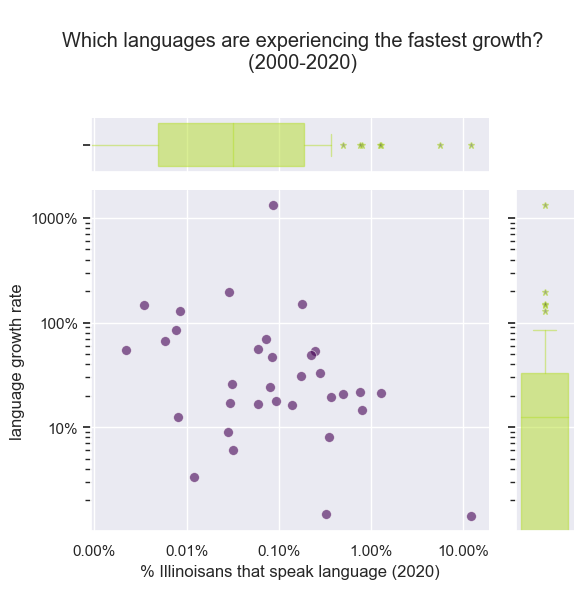

In [323]:
# explore 2020 pct weight vs. 2000-2020 growth rate

# temporarily only show final output
InteractiveShell.ast_node_interactivity = 'last_expr'

# set up color preferences
c_box = '#b5de2b'
c_scatter = '#440154'

# plot
g_language_growth_v_weight = sns.JointGrid(
    data = s_language_growth_over_time,
    x = 'yr2020',
    y = 'growth_2000_2020',
    marginal_ticks = True,
    )

g_language_growth_v_weight.plot_joint(
    sns.scatterplot,
    alpha = 0.6,
    color = c_scatter,
    s = 50,
)
g_language_growth_v_weight.plot_marginals(
    sns.boxplot,
    linewidth = 1,
    boxprops = {
        'facecolor': c_box,
        'edgecolor': c_box,
        'alpha': 0.5,
    },
    flierprops = {
        'color': c_box,
        'alpha': 0.5,
        'marker': '*',
        'markeredgecolor': c_box,
        'markeredgecolor': c_box,
    },
    medianprops = {
        'color': c_box,
        'alpha': 0.5,
    },
    whiskerprops = {
        'color': c_box,
        'alpha': 0.5,
    },
    capprops = {
        'color': c_box,
        'alpha': 0.5,
    },
)

# format axes
g_language_growth_v_weight.ax_joint.set_xscale('log')
g_language_growth_v_weight.ax_joint.xaxis.set_major_formatter(
    mtick.PercentFormatter(xmax = 1, decimals = 2)
)

g_language_growth_v_weight.ax_joint.set_yscale('log')
g_language_growth_v_weight.ax_joint.yaxis.set_major_formatter(
    mtick.PercentFormatter(xmax = 1)
)
# add labels and title
g_language_growth_v_weight.set_axis_labels(
    xlabel = '% Illinoisans that speak language (2020)',
    ylabel = 'language growth rate',
)
g_language_growth_v_weight.fig.suptitle(
    """
    Which languages are experiencing the fastest growth?
    (2000-2020)
    """
)
g_language_growth_v_weight.fig.tight_layout()
# save plot
g_language_growth_v_weight.savefig(os.path.join(od, 'fastest_growth.jpg'))

In [257]:
# focus on Asian language trends. there are 331 Asian languages so focus on
# the ones that are in at least one of the following categories:
# 1. top 10 in percent weight
# 2. top 10 in 20-year growth rate

# create summary of Asian languages by year
s_asian_over_time = (d_wp[d_wp.language_group == 'Asian']
    .groupby(['year', 'language'])
    .agg(n_sample = ('person_id', 'count'), sum_weight = ('perwt', 'sum'))
    .reset_index()
    .merge(s_year, how = "left", on = "year")
    .drop('household_sum_weight', axis = 'columns')
    .assign(pct_weight = lambda x: x.sum_weight/x.person_sum_weight)
)

# identify top languages
top10_pct = (s_asian_over_time[s_asian_over_time.year == 2020]
    .nlargest(10, 'pct_weight')
)
top10_growth = (s_language_growth_over_time[
    s_language_growth_over_time.language_group == 'Asian']
    .nlargest(10, 'growth_2000_2020')
)
top = pd.concat([top10_pct['language'], top10_growth['language']])
top.drop_duplicates(inplace = True)

s_asian_over_time_top = s_asian_over_time[s_asian_over_time.language.isin(top)]
s_asian_over_time_top.value_counts('language')
glimpse(s_asian_over_time_top)

Rows: 287
Columns: 6
$ year <int64> [2000 2000 2000 2000 2000]
$ language <object> ['Chinese' 'Dravidian' 'Filipino, Tagalog' 'Hindi and related'
 'Indonesian']
$ n_sample <int64> [ 72  33 109 105   1]
$ sum_weight <float64> [63785. 22935. 88445. 77645.   628.]
$ person_sum_weight <float64> [12123016. 12123016. 12123016. 12123016. 12123016.]
$ pct_weight <float64> [5.26147949e-03 1.89185595e-03 7.29562676e-03 6.40475934e-03
 5.18022908e-05]


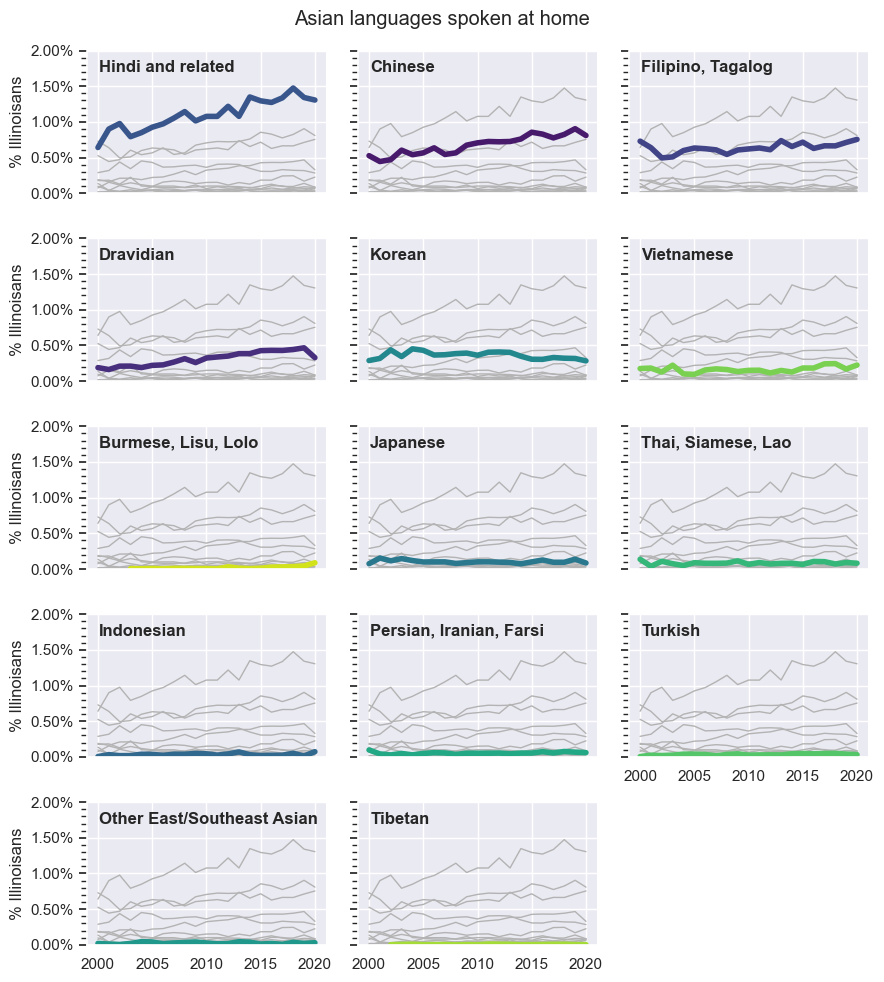

In [278]:
# plot growth of "top" Asian languages over last 20 years

# define order of languages by their 2020 percent weight
language_order = (s_asian_over_time_top[s_asian_over_time_top.year == 2020]
    .sort_values(by = 'pct_weight', ascending = False)
    ).language

# create base figure
g_asian_over_time = sns.relplot(
    data = s_asian_over_time_top,
    x = 'year', 
    y = 'pct_weight', 
    kind = 'line',
    col = 'language',
    col_wrap = 3,
    col_order = language_order,
    hue = 'language',
    palette = 'viridis',
    linewidth = 4,
    height = 2,
    aspect = 1.5,
    legend = False,
)

# format each subplot
for group, ax in g_asian_over_time.axes_dict.items():

    # add the title as an annotation within the plot
    ax.text(
        x = 0.05, 
        y = 0.85,
        s = group,
        transform = ax.transAxes, 
        fontweight = 'bold'
    )

    # plot every language group's time series in the background
    sns.lineplot(
        data = s_asian_over_time_top, 
        x = 'year', 
        y = 'pct_weight', 
        units = 'language',
        estimator = None, 
        color = '0.7', 
        linewidth = 1, 
        ax = ax,
        zorder = 1
    )

    # format y-axis: ticks and as-percents
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    ax.set_ylim(0, 0.02)
    ax.minorticks_on()

# add labels and title
g_asian_over_time.set(
    title = '',
    xlabel = '',
    ylabel = '% Illinoisans'
)
g_asian_over_time.fig.suptitle('Asian languages spoken at home')
g_asian_over_time.tight_layout()

# save plot
g_asian_over_time.savefig(os.path.join(od, 'asian_time_series.jpg'))

# How do citizenship status and language spoken relate?

In [302]:
# add English and Citizen booleans
d_wp = (d_wp
    .assign(english = lambda x: x.language == 'English')
    .assign(citizen = lambda x: x.citizenship_status != 'Not a citizen')
)
d_wp.value_counts('english')
d_wp.value_counts('citizen')

english
True     1727716
False     480542
dtype: int64

citizen
True     2094595
False     113663
dtype: int64

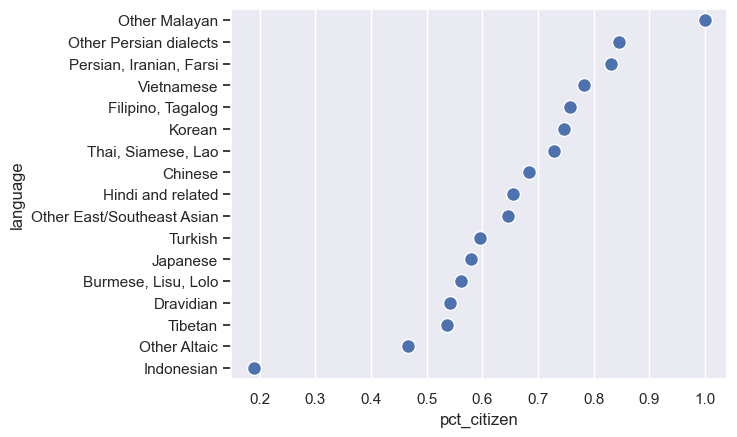

In [357]:
# TO DO:
# - play around with faceting years or animating timeline
# - format color, axes, etc.

# go back to showing all outputs
InteractiveShell.ast_node_interactivity = 'all'

# create total weights per Asian language per year
s_language_year = (d_wp[d_wp.language_group == 'Asian']
    .groupby(['year', 'language'])
    .agg(language_sum_weight = ('perwt', 'sum'))
)

# summarize citizenship prevalency by language
s_citizens = (d_wp[d_wp.language_group == 'Asian']
    .assign(citizen_wt = lambda x: x.citizen * x.perwt)
    .groupby(['year', 'language'])
    .agg(citizen_wt = ('citizen_wt', 'sum'))
    .reset_index()
    .merge(s_language_year, how = 'left', on = ['year', 'language'])
    .assign(pct_citizen = lambda x: x.citizen_wt/x.language_sum_weight)
    .sort_values(
        by = 'pct_citizen',
        ascending = False,
    )
)

# plot
g_citizenship = sns.stripplot(
    data = s_citizens[s_citizens.year == 2020],
    x = 'pct_citizen', 
    y = 'language',
    #hue = 'year',
    size = 10, 
    orient = 'h', 
    jitter = False,
    #palette = 'viridis', 
    linewidth = 1, 
    edgecolor = 'w'
)

# How do household income and language spoken relate?